In [1]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:

#dataset =pd.read_csv('./data/SMOTE_data.csv')
dataset=pd.read_csv('./data/SMOTE_data.csv')
df = dataset.copy()


Client 1 label distribution: (array([1], dtype=int64), array([6], dtype=int64))
Client 2 label distribution: (array([1], dtype=int64), array([1], dtype=int64))
Client 3 label distribution: (array([1], dtype=int64), array([3], dtype=int64))
Client 4 label distribution: (array([], dtype=int64), array([], dtype=int64))
Client 5 label distribution: (array([1], dtype=int64), array([6], dtype=int64))
Client 6 label distribution: (array([], dtype=int64), array([], dtype=int64))
Client 7 label distribution: (array([1], dtype=int64), array([56], dtype=int64))
Client 8 label distribution: (array([1], dtype=int64), array([1], dtype=int64))
Client 9 label distribution: (array([1], dtype=int64), array([8], dtype=int64))
Client 10 label distribution: (array([], dtype=int64), array([], dtype=int64))


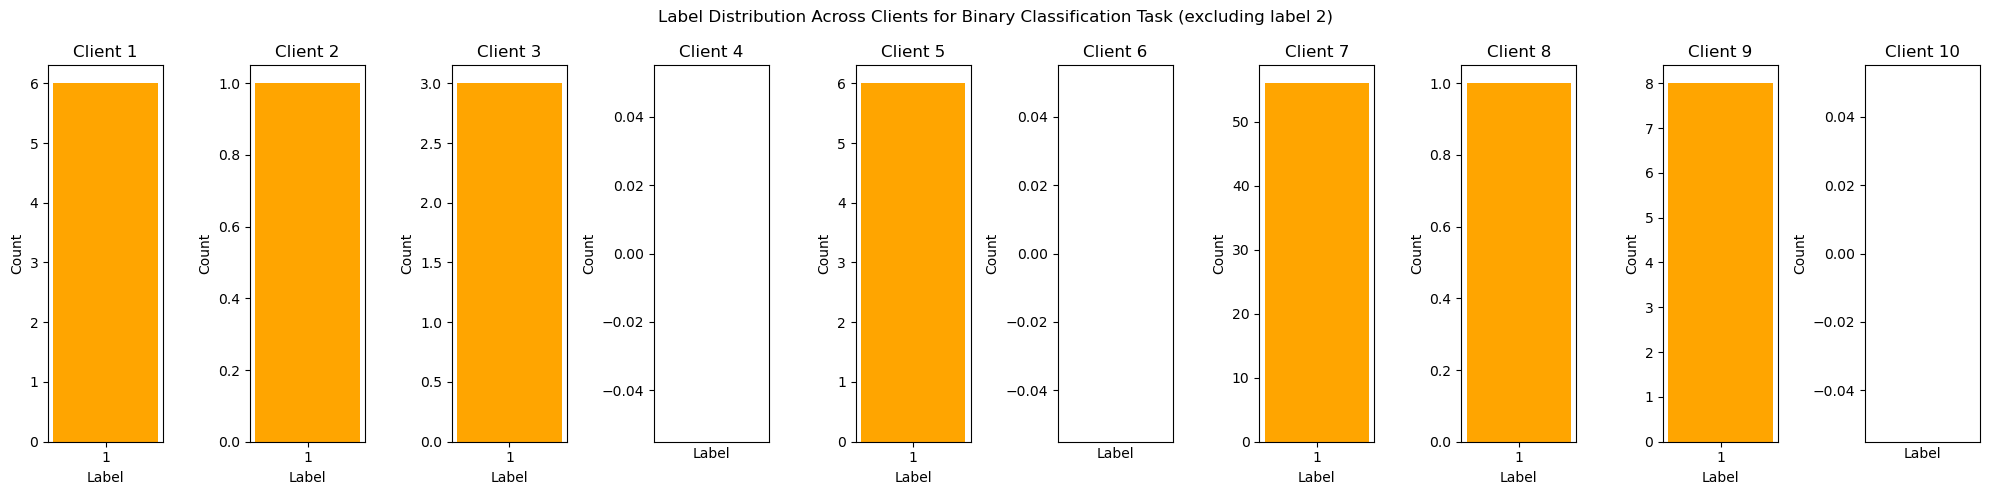

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame creation (replace this with your actual DataFrame)
data = {
    'dst2src_first_seen_ms': np.random.rand(100),
    'dst2src_last_seen_ms': np.random.rand(100),
    'dst2src_max_piat_ms': np.random.rand(100),
    'bidirectional_syn_packets': np.random.rand(100),
    'src2dst_syn_packets': np.random.rand(100),
    'application_is_guessed': np.random.randint(0, 2, 100),
    'application_confidence': np.random.rand(100),
    'label_mul': np.random.randint(0, 15, 100)
}

df = pd.DataFrame(data)

# Create binary labels
df['binary_label'] = df['label_mul'].apply(lambda x: 0 if x == 0 else 1)

# Prepare features and labels
features = df.drop(columns=['label_mul', 'binary_label', 'application_is_guessed', 'application_confidence'])
labels = df['binary_label'].values

# Number of clients and Dirichlet parameter
num_clients = 10
alpha = 0.5  # Adjust this value to encourage more balanced distributions

# Distribute data using Dirichlet distribution among clients
def distribute_data_dirichlet(X, y, num_clients, alpha):
    y_labels = np.argmax(y, axis=1) if y.ndim > 1 else y
    N = len(y_labels)
    np.random.seed(42)
    indices = [np.where(y_labels == i)[0] for i in range(len(np.unique(y_labels)))]
    
    # Generate proportions using Dirichlet distribution
    proportions = [np.random.dirichlet(np.repeat(alpha, num_clients)) for _ in range(len(np.unique(y_labels)))]
    
    # Normalize proportions
    proportions = np.array([p * (len(ind) / N) for p, ind in zip(proportions, indices)])
    
    idx_batch = [[] for _ in range(num_clients)]
    
    # Distribute indices based on proportions
    for c, fracs in enumerate(proportions):
        for i in range(num_clients):
            # Get the number of samples to take for this client
            num_samples = int(fracs[i] * len(indices[c]))
            idx_batch[i].extend(indices[c][:num_samples])
    
    # Create clients data
    clients_data = [(X[idx_batch[i]], y[idx_batch[i]]) for i in range(num_clients)]
    
    # Debugging: Print the distribution of labels for each client
    for i, (X_client, y_client) in enumerate(clients_data):
        print(f'Client {i + 1} label distribution: {np.unique(y_client, return_counts=True)}')
    
    return clients_data

# Call the function to distribute data
clients_data = distribute_data_dirichlet(features.values, labels, num_clients, alpha)

# Plot label distribution for each client
def plot_label_distribution(clients_data, task_name, exclude_label=2):
    num_clients = len(clients_data)
    fig, axes = plt.subplots(1, num_clients, figsize=(20, 5), tight_layout=True)
    fig.suptitle(f'Label Distribution Across Clients for {task_name} Task (excluding label {exclude_label})')
    
    for i, (X_client, y_client) in enumerate(clients_data):
        # If y_client is one-hot encoded, use np.argmax to get the labels
        labels = np.argmax(y_client, axis=1) if y_client.ndim > 1 else y_client
        # Exclude the specified label
        labels = labels[labels != exclude_label]
        unique, counts = np.unique(labels, return_counts=True)
        
        # Set colors for normal and attack
        colors = ['blue' if label == 0 else 'orange' for label in unique]
        
        axes[i].bar(unique, counts, color=colors)
        axes[i].set_title(f'Client {i + 1}')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Count')
        axes[i].set_xticks(unique)
    
    plt.show()

# Call the plotting function
plot_label_distribution(clients_data, task_name='Binary Classification', exclude_label=2)

In [4]:
import numpy as np
import pandas as pd



# Create binary labels
df['binary_label'] = df['label_mul'].apply(lambda x: 0 if x == 0 else 1)

# Prepare features and labels

labels = df['binary_label'].values

# Number of clients
num_clients = 5

# Distribute data IID among clients
def distribute_data_iid(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled, y_shuffled = X[indices], y[indices]
    data_size_per_client = len(X_shuffled) // num_clients
    clients_data = [(X_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client],
                     y_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client]) for i in range(num_clients)]
    if len(X_shuffled) % num_clients != 0:
        clients_data[-1] = (np.concatenate((clients_data[-1][0], X_shuffled[num_clients * data_size_per_client:])),
                            np.concatenate((clients_data[-1][1], y_shuffled[num_clients * data_size_per_client:])))
    return clients_data

# Call the function
clients_data = distribute_data_iid(features.values, labels, num_clients)

# Output the distributed data for each client
for i, (X_client, y_client) in enumerate(clients_data):
    print(f"Client {i + 1}:")
    print("Features:\n", X_client)
    print("Labels:\n", y_client)
    print("\n")

Client 1:
Features:
 [[0.3499626  0.67000164 0.89813604 0.49033698 0.51683815]
 [0.68483169 0.08247687 0.67473027 0.03060058 0.88471668]
 [0.87449252 0.52211466 0.65097414 0.38477309 0.02870143]
 [0.63509499 0.46905389 0.11154376 0.33621743 0.06227883]
 [0.50669669 0.03765608 0.57660808 0.10243923 0.39773732]
 [0.40878527 0.93074798 0.40241851 0.64972579 0.30401844]
 [0.74677948 0.19199706 0.96895443 0.99093757 0.89403357]
 [0.27804522 0.65607182 0.88579383 0.85688283 0.49735781]
 [0.23153776 0.35866946 0.14457174 0.56856948 0.29534077]
 [0.31210035 0.65200377 0.29916499 0.46041122 0.24421828]
 [0.54676282 0.09831107 0.27431346 0.80717591 0.26777399]
 [0.55753145 0.02187674 0.03870215 0.64673119 0.05474902]
 [0.75112098 0.28683256 0.97996082 0.77230754 0.33478579]
 [0.60291805 0.11251639 0.2472613  0.81032134 0.45994014]
 [0.92276865 0.91480677 0.37253269 0.72654938 0.37745642]
 [0.87604873 0.59199798 0.61275051 0.87827138 0.92505908]
 [0.50730338 0.04005948 0.4393216  0.54326569 0.202

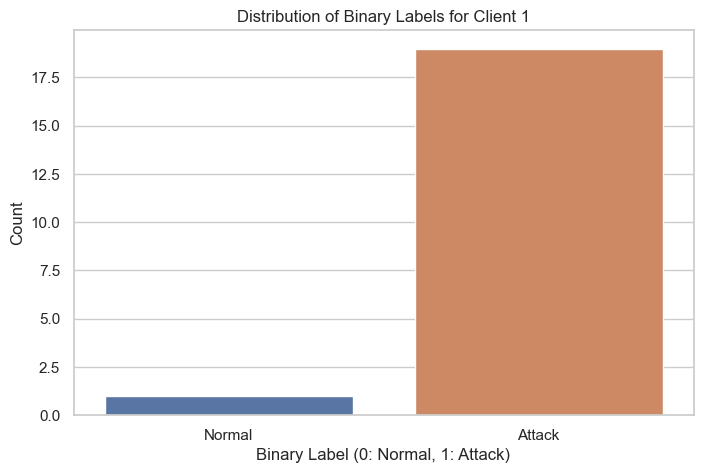

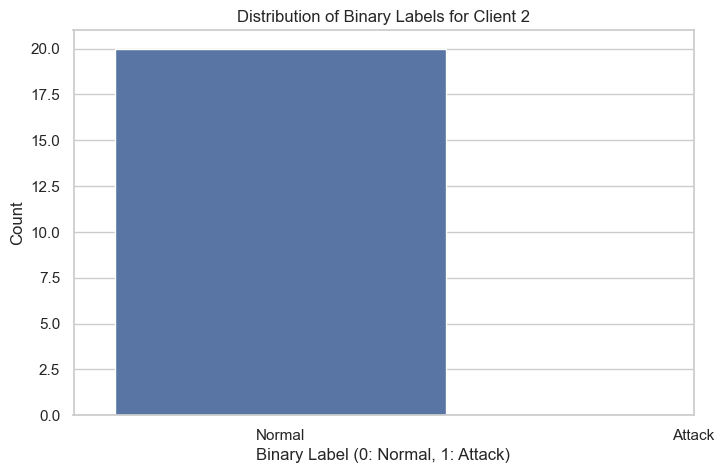

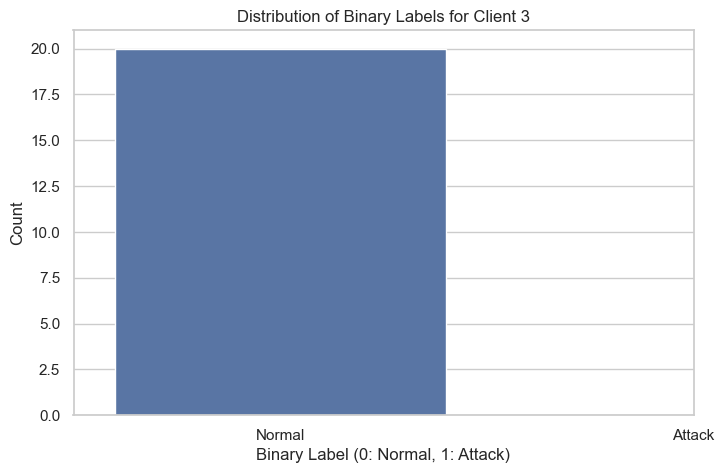

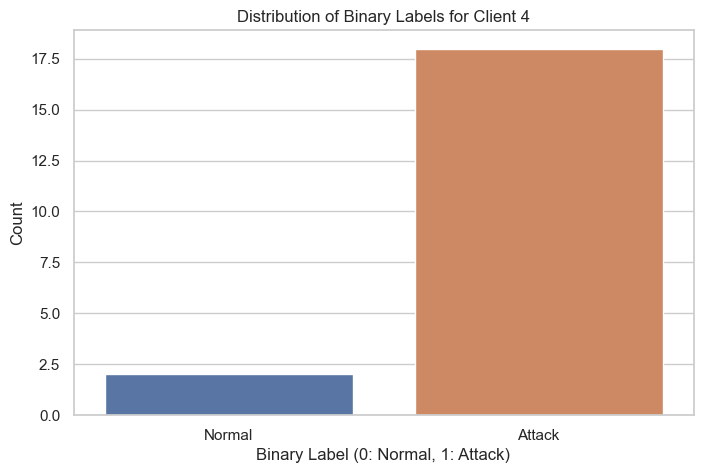

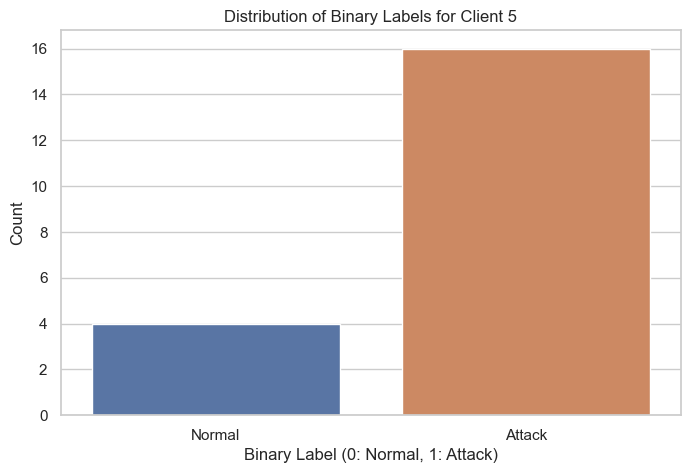

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Plot histograms for each client
for i, (X_client, y_client) in enumerate(clients_data):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_client)
    plt.title(f'Distribution of Binary Labels for Client {i + 1}')
    plt.xlabel('Binary Label (0: Normal, 1: Attack)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Normal', 'Attack'])
    plt.show()

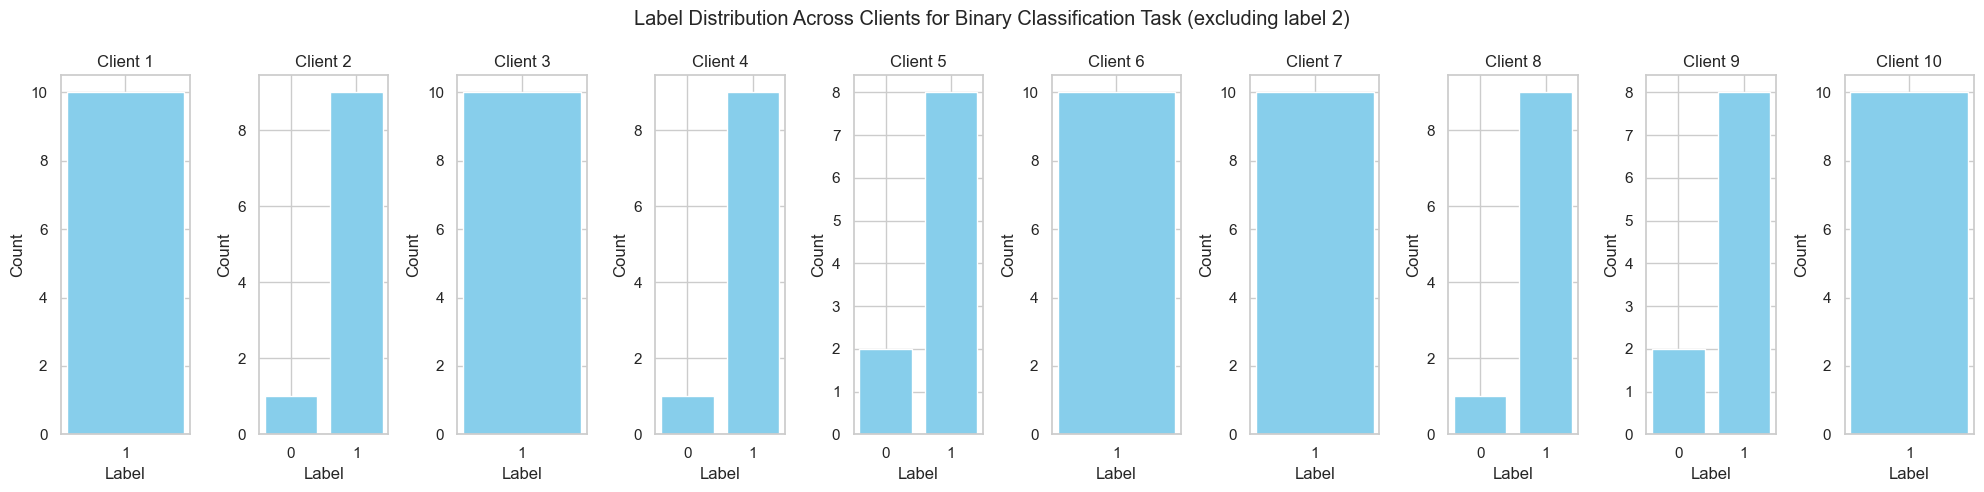

In [6]:
# Prepare features and labels

labels = df['binary_label'].values

# Number of clients
num_clients = 10

# Distribute data IID among clients
def distribute_data_iid(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled, y_shuffled = X[indices], y[indices]
    data_size_per_client = len(X_shuffled) // num_clients
    clients_data = [(X_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client],
                     y_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client]) for i in range(num_clients)]
    if len(X_shuffled) % num_clients != 0:
        clients_data[-1] = (np.concatenate((clients_data[-1][0], X_shuffled[num_clients * data_size_per_client:])),
                            np.concatenate((clients_data[-1][1], y_shuffled[num_clients * data_size_per_client:])))
    return clients_data

# Call the function
clients_data = distribute_data_iid(features.values, labels, num_clients)

# Plot label distribution for each client
def plot_label_distribution(clients_data, task_name, exclude_label=2):
    num_clients = len(clients_data)
    fig, axes = plt.subplots(1, num_clients, figsize=(20, 5), tight_layout=True)
    fig.suptitle(f'Label Distribution Across Clients for {task_name} Task (excluding label {exclude_label})')
    
    for i, (X_client, y_client) in enumerate(clients_data):
        # If y_client is one-hot encoded, use np.argmax to get the labels
        labels = np.argmax(y_client, axis=1) if y_client.ndim > 1 else y_client
        # Exclude the specified label
        labels = labels[labels != exclude_label]
        unique, counts = np.unique(labels, return_counts=True)
        
        axes[i].bar(unique, counts, color='skyblue')
        axes[i].set_title(f'Client {i + 1}')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Count')
        axes[i].set_xticks(unique)
    
    plt.show()

# Call the plotting function
plot_label_distribution(clients_data, task_name='Binary Classification', exclude_label=2)

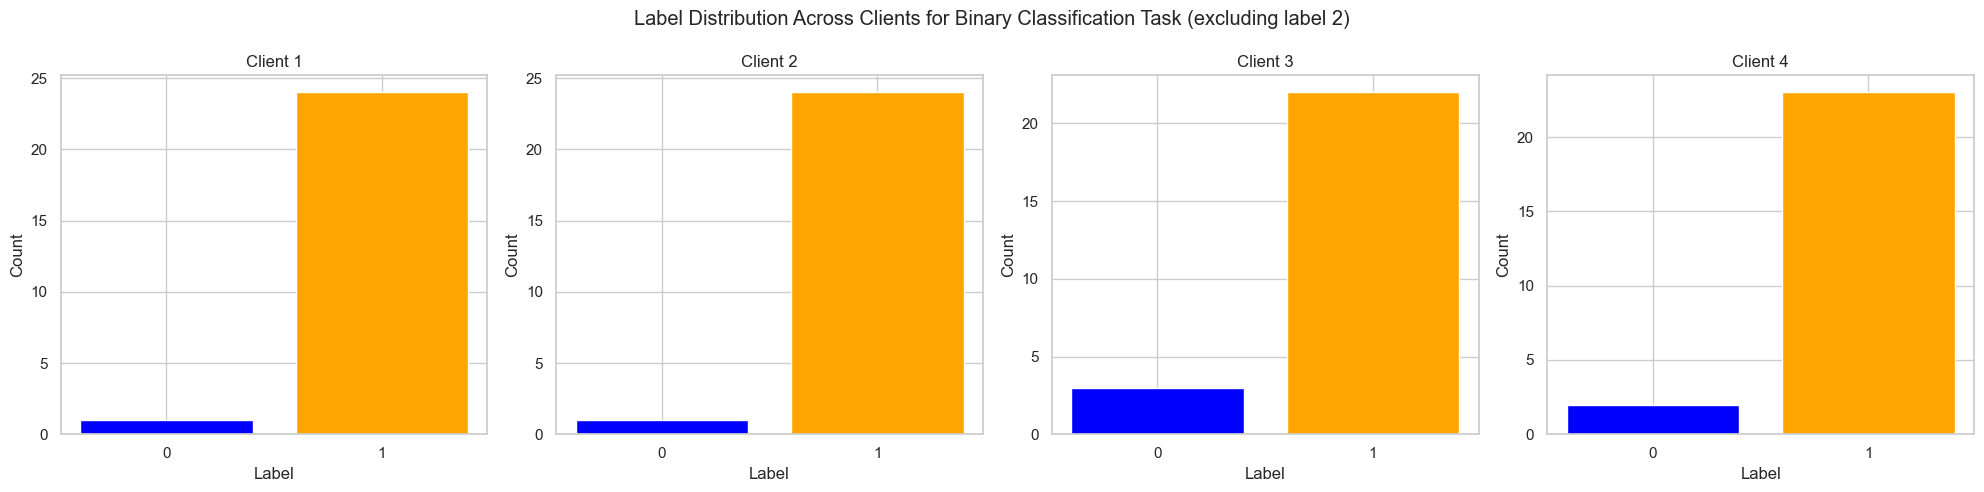

In [7]:
# Number of clients
num_clients = 4

# Distribute data IID among clients
def distribute_data_iid(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled, y_shuffled = X[indices], y[indices]
    data_size_per_client = len(X_shuffled) // num_clients
    clients_data = [(X_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client],
                     y_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client]) for i in range(num_clients)]
    if len(X_shuffled) % num_clients != 0:
        clients_data[-1] = (np.concatenate((clients_data[-1][0], X_shuffled[num_clients * data_size_per_client:])),
                            np.concatenate((clients_data[-1][1], y_shuffled[num_clients * data_size_per_client:])))
    return clients_data

# Call the function
clients_data = distribute_data_iid(features.values, labels, num_clients)

# Plot label distribution for each client
def plot_label_distribution(clients_data, task_name, exclude_label=2):
    num_clients = len(clients_data)
    fig, axes = plt.subplots(1, num_clients, figsize=(20, 5), tight_layout=True)
    fig.suptitle(f'Label Distribution Across Clients for {task_name} Task (excluding label {exclude_label})')
    
    for i, (X_client, y_client) in enumerate(clients_data):
        # If y_client is one-hot encoded, use np.argmax to get the labels
        labels = np.argmax(y_client, axis=1) if y_client.ndim > 1 else y_client
        # Exclude the specified label
        labels = labels[labels != exclude_label]
        unique, counts = np.unique(labels, return_counts=True)
        
        # Set colors for normal and attack
        colors = ['blue' if label == 0 else 'orange' for label in unique]
        
        axes[i].bar(unique, counts, color=colors)
        axes[i].set_title(f'Client {i + 1}')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Count')
        axes[i].set_xticks(unique)
    
    plt.show()

# Call the plotting function
plot_label_distribution(clients_data, task_name='Binary Classification', exclude_label=2)

Client 1 label distribution: (array([1], dtype=int64), array([3], dtype=int64))
Client 2 label distribution: (array([1], dtype=int64), array([1], dtype=int64))
Client 3 label distribution: (array([1], dtype=int64), array([39], dtype=int64))
Client 4 label distribution: (array([1], dtype=int64), array([18], dtype=int64))
Client 5 label distribution: (array([1], dtype=int64), array([24], dtype=int64))


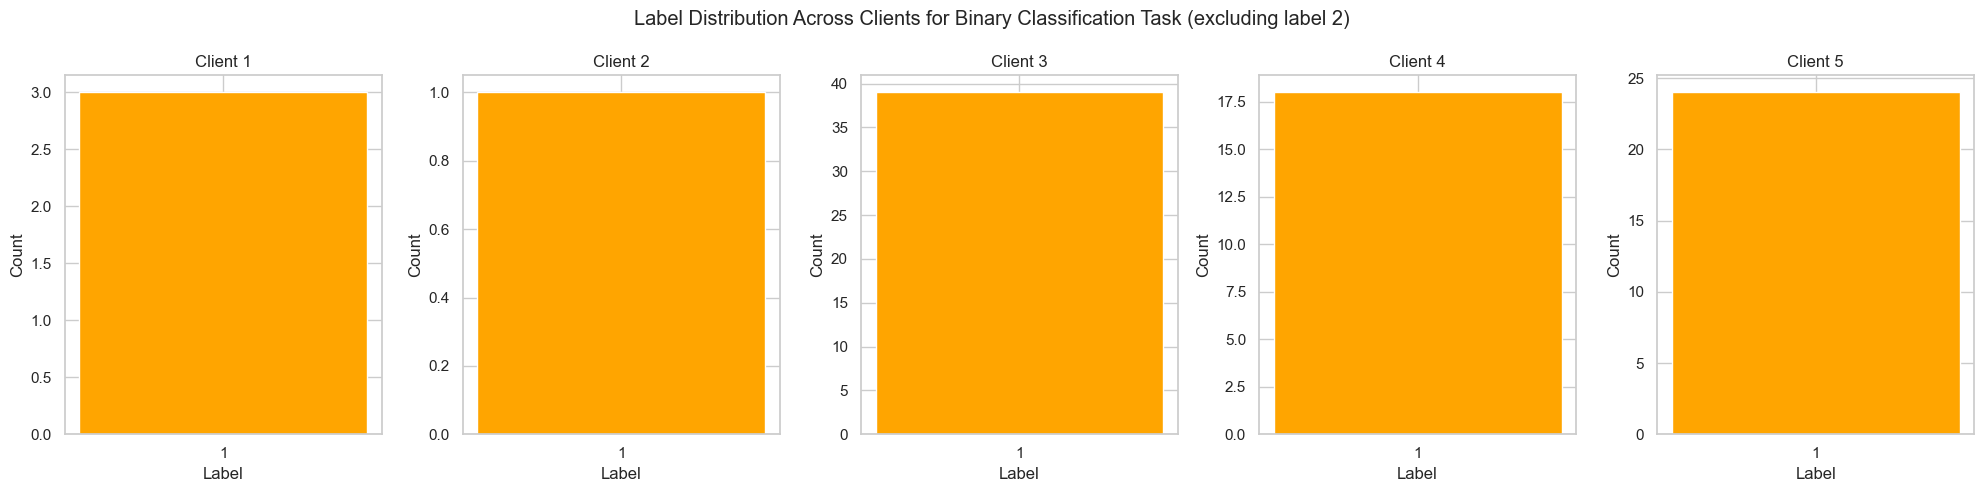

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame creation (replace this with your actual DataFrame)
data = {
    'dst2src_first_seen_ms': np.random.rand(100),
    'dst2src_last_seen_ms': np.random.rand(100),
    'dst2src_max_piat_ms': np.random.rand(100),
    'bidirectional_syn_packets': np.random.rand(100),
    'src2dst_syn_packets': np.random.rand(100),
    'application_is_guessed': np.random.randint(0, 2, 100),
    'application_confidence': np.random.rand(100),
    'label_mul': np.random.randint(0, 15, 100)
}

df = pd.DataFrame(data)

# Create binary labels
df['binary_label'] = df['label_mul'].apply(lambda x: 0 if x == 0 else 1)

# Prepare features and labels
features = df.drop(columns=['label_mul', 'binary_label', 'application_is_guessed', 'application_confidence'])
labels = df['binary_label'].values

# Number of clients and Dirichlet parameter
num_clients = 5
alpha = 1.0  # Increase this value to encourage more balanced distributions

# Distribute data using Dirichlet distribution among clients
def distribute_data_dirichlet(X, y, num_clients, alpha):
    y_labels = np.argmax(y, axis=1) if y.ndim > 1 else y
    N = len(y_labels)
    np.random.seed(42)
    indices = [np.where(y_labels == i)[0] for i in range(len(np.unique(y_labels)))]
    
    # Generate proportions using Dirichlet distribution
    proportions = [np.random.dirichlet(np.repeat(alpha, num_clients)) for _ in range(len(np.unique(y_labels)))]
    
    # Normalize proportions
    proportions = np.array([p * (len(ind) / N) for p, ind in zip(proportions, indices)])
    
    idx_batch = [[] for _ in range(num_clients)]
    
    # Distribute indices based on proportions
    for c, fracs in enumerate(proportions):
        for i in range(num_clients):
            # Get the number of samples to take for this client
            num_samples = int(fracs[i] * len(indices[c]))
            idx_batch[i].extend(indices[c][:num_samples])
    
    # Create clients data
    clients_data = [(X[idx_batch[i]], y[idx_batch[i]]) for i in range(num_clients)]
    
    # Debugging: Print the distribution of labels for each client
    for i, (X_client, y_client) in enumerate(clients_data):
        print(f'Client {i + 1} label distribution: {np.unique(y_client, return_counts=True)}')
    
    return clients_data

# Call the function to distribute data
clients_data = distribute_data_dirichlet(features.values, labels, num_clients, alpha)

# Plot label distribution for each client
def plot_label_distribution(clients_data, task_name, exclude_label=2):
    num_clients = len(clients_data)
    fig, axes = plt.subplots(1, num_clients, figsize=(20, 5), tight_layout=True)
    fig.suptitle(f'Label Distribution Across Clients for {task_name} Task (excluding label {exclude_label})')
    
    for i, (X_client, y_client) in enumerate(clients_data):
        # If y_client is one-hot encoded, use np.argmax to get the labels
        labels = np.argmax(y_client, axis=1) if y_client.ndim > 1 else y_client
        # Exclude the specified label
        labels = labels[labels != exclude_label]
        unique, counts = np.unique(labels, return_counts=True)
        
        # Set colors for normal and attack
        colors = ['blue' if label == 0 else 'orange' for label in unique]
        
        axes[i].bar(unique, counts, color=colors)
        axes[i].set_title(f'Client {i + 1}')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Count')
        axes[i].set_xticks(unique)
    
    plt.show()

# Call the plotting function
plot_label_distribution(clients_data, task_name='Binary Classification', exclude_label=2)

In [9]:
# Generate proportions using Dirichlet distribution
proportions = [np.random.dirichlet(np.repeat(alpha, num_clients)) for _ in range(len(np.unique(y_labels)))]

# Normalize proportions
proportions = np.array([p * (len(ind) / N) for p, ind in zip(proportions, indices)])

idx_batch = [[] for _ in range(num_clients)]

# Distribute indices based on proportions
for c, fracs in enumerate(proportions):
    for i in range(num_clients):
        # Get the number of samples to take for this client
        num_samples = int(fracs[i] * len(indices[c]))
        idx_batch[i].extend(indices[c][:num_samples])

# Create clients data
clients_data = [(X[idx_batch[i]], y[idx_batch[i]]) for i in range(num_clients)]

# Debugging: Print the distribution of labels for each client
for i, (X_client, y_client) in enumerate(clients_data):
    print(f'Client {i + 1} label distribution: {np.unique(y_client, return_counts=True)}')

return clients_data

NameError: name 'y_labels' is not defined

In [44]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(df.drop(columns=['label_mul']), data['label_mul'])

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 6

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, LSTM, GlobalAveragePooling1D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import time

In [6]:
# Split the resampled data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)
print(X_train.shape[0])

6371352


In [7]:
# Distribute data IID among clients
def distribute_data_iid(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled, y_shuffled = X[indices], y[indices]
    data_size_per_client = len(X_shuffled) // num_clients
    clients_data = [(X_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client],
                     y_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client]) for i in range(num_clients)]
    if len(X_shuffled) % num_clients != 0:
        clients_data[-1] = (np.concatenate((clients_data[-1][0], X_shuffled[num_clients * data_size_per_client:])),
                            np.concatenate((clients_data[-1][1], y_shuffled[num_clients * data_size_per_client:])))
    return clients_data

In [8]:
distribute_data_iid(X_train,y_train,5)

KeyError: "None of [Index([6012132, 3898455, 1242075, 1056414, 1746212, 2186583, 2931972, 2178800,\n       5378619, 4102562,\n       ...\n       5443831, 4333948, 1148588, 6001028, 4276224, 5663700, 2251998, 2287663,\n        939546, 3293139],\n      dtype='int32', length=6371352)] are in the [columns]"

In [ ]:


# Standardize the data to have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for CNN-LSTM input (samples, timesteps, features)
# Here, we treat each feature as a timestep with a single feature
# Alternatively, you can choose to treat the entire feature vector as a single timestep with multiple features
# Adjust reshaping based on your specific data and problem
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the Hybrid CNN-LSTM model
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        # Convolutional layers to extract local features
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        Dropout(0.4),
        BatchNormalization(),

        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        Dropout(0.4),
        BatchNormalization(),

        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        Dropout(0.4),
        BatchNormalization(),

        # LSTM layers to capture sequential dependencies
        LSTM(128, return_sequences=True, activation='tanh'),
        Dropout(0.4),
        BatchNormalization(),

        LSTM(64, activation='tanh'),
        Dropout(0.4),
        BatchNormalization(),

        # Fully connected output layer
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train the Hybrid CNN-LSTM model
model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]), len(np.unique(y_train)))

# Record the start time for training
start_time_training = time.time()

# Train the model with validation split
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=50,
                    verbose=1,
                    validation_split=0.2)

# Record the end time for training
end_time_training = time.time()

# Calculate the training time
training_time = end_time_training - start_time_training
print(f'Training Time: {training_time:.2f} seconds')

# Record the start time for testing
start_time_testing = time.time()

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Record the end time for testing
end_time_testing = time.time()

# Calculate the testing time
testing_time = end_time_testing - start_time_testing
print(f'Testing Time: {testing_time:.2f} seconds')

# Calculate and print additional metrics
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Plotting accuracy and loss curves for training and validation
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1363512
Epoch 1/50
1469/2131 ━━━━━━━━━━━━━━━━━━━━ 2:21 213ms/step - accuracy: 0.5711 - loss: 1.0478